In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [13]:
data = Path.cwd().parent / 'data'
df = pd.read_csv(data / 'limpo_solicitacoes_doc9.csv',
    parse_dates=[
        'datahora_abertura_solicitacao',
        'datahora_finalizacao_solicitacao',
        'datahora_audiencia',
        'prazo_para_inserir_dados',
        ]
    )
df = df.drop(columns=['Unnamed: 0'])

# Produto
_Pergunta do stakeholder:_

_“Estamos recebendo muitas reclamações sobre trocas de audiencistas. Quais clientes têm maior incidência de trocas ou recusas? Existem padrões por região ou tipo de audiência?”_

In [3]:
df_prob_client = (
    df
    .groupby([
        'nome_cliente', 'tipo_audiencia', 'comarca'
        ])
    .agg({
        'qtd_troca': 'sum',
        'qtd_declinio': 'sum',
        }
        )
    .assign(total_nao_comparecimento=lambda x: x['qtd_troca'] + x['qtd_declinio'])
    .query('qtd_troca > 0 | qtd_declinio > 0 | total_nao_comparecimento > 0')
    .sort_values('total_nao_comparecimento', ascending=False)
    .reset_index()
    .query('total_nao_comparecimento != 0')
    .rename(columns={
        'nome_cliente': 'Nome do Cliente',
        'comarca': 'Comarca',
        'tipo_audiencia': 'Tipo de Audiência',
        'qtd_troca': 'Soma da quantidade de pedidos de troca',
        'qtd_declinio': 'Soma da quantidade de vezes declinada',
        'total_nao_comparecimento': 'Soma total de ocorrencias negativas'
    })
)

df_prob_client

,Nome do Cliente,Tipo de Audiência,Comarca,Soma da quantidade de pedidos de troca,Soma da quantidade de vezes declinada,Soma total de ocorrencias negativas
0,DA CRUZ,UNA,FORTALEZA - CE,42,18,60
1,BORGES,UNA,São Paulo - SP,17,39,56
2,CAVALCANTE CUNHA - EI,UNA,São Paulo - SP,12,39,51
3,SOUSA,Instrucao,Rio de Janeiro - RJ,5,23,28
4,DA CRUZ,Instrucao,Rio de Janeiro - RJ,8,14,22
...,...,...,...,...,...,...
1642,ALBUQUERQUE,Conciliacao,Taubaté - SP,0,1,1
1643,ALBUQUERQUE,Conciliacao,São Luis - MA,0,1,1
1644,ALBUQUERQUE,Conciliacao,Serra - ES,0,1,1
1645,ALBUQUERQUE,Conciliacao,Rio Negrinho - SC,0,1,1


A tabela acima ilustra a quantidade de vezes que determinado cliente se recusou ou pleiteou pela troca de um parceiro da Doc9 em determinada comarca.

A tabela está organizada de maneira decrescente, de acordo com a quantidade de total de ocorrências negativas.

É interessante destrinchar, entretanto, se há padrão por tipo de audência ou região, o que pode sugerir um caminho para solucionar o problema encontrado.

In [4]:
(
    df_prob_client
    .groupby('Nome do Cliente')
    .agg({'Soma total de ocorrencias negativas': 'sum'})
    .sort_values('Soma total de ocorrencias negativas', ascending=False)
    .head(10)
)

,Soma total de ocorrencias negativas
Nome do Cliente,
DA CRUZ,331
SOUSA,330
OLIVEIRA FREITAS - ME,298
CAVALCANTE CUNHA - EI,232
DA MATA,145
DA PAZ MONTENEGRO S.A.,136
BORGES,130
PIRES - EI,114
BARROS,107


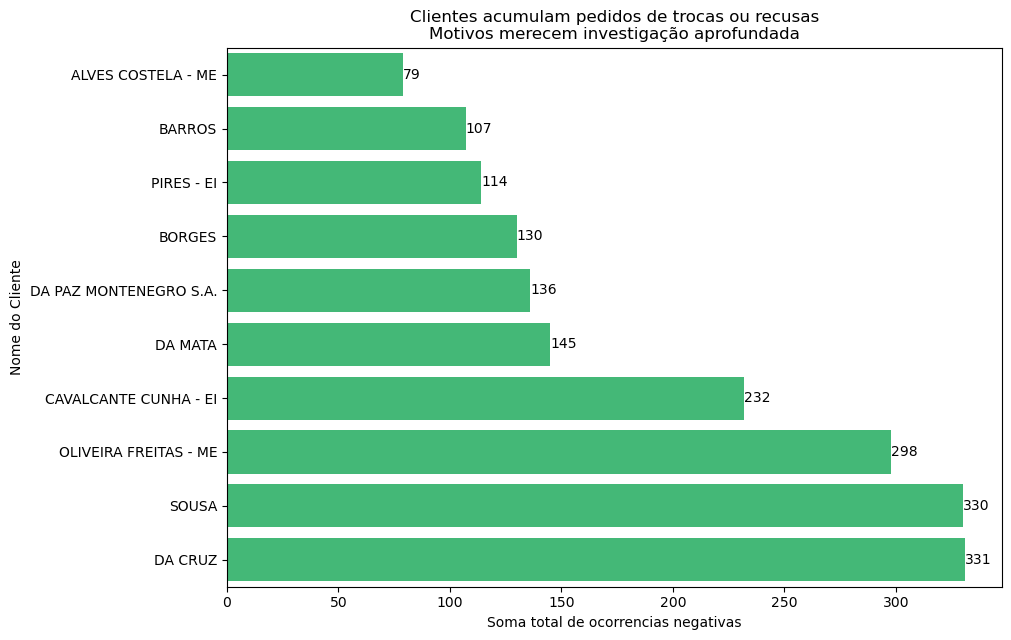

In [5]:
plt.figure(figsize=(10, 7))

prob_client_plt = sns.barplot(
    orient='h',
    data=(
        df_prob_client
        .groupby('Nome do Cliente')
        .agg({'Soma total de ocorrencias negativas': 'sum'})
        .sort_values('Soma total de ocorrencias negativas', ascending=True)
        .tail(10)
        ),
    y='Nome do Cliente',
    x='Soma total de ocorrencias negativas',
    color='#31cb74',
    )

for container in prob_client_plt.containers:
    bar_values = [bar.get_width() for bar in container]
    prob_client_plt.bar_label(
            container,
            color='black',
            label_type='edge'
            )

plt.title(
    'Clientes acumulam pedidos de trocas ou recusas\n' + \
        'Motivos merecem investigação aprofundada'
    );

## Porcentagem de solicitações não atendidas por UF

É possível agrupar as _solicitações inviabilizadas_ por unidade federativa para determinar se algum Estado do país é atendido por um (ou mais) parceiro(s) particularmente rejeitado.

In [6]:
(
    df
    .assign(
        total_nao_comparecimento=lambda x: x['qtd_troca'] + x['qtd_declinio']
        )
    .groupby('uf_comarca')
    [['qtd_troca', 'qtd_declinio', 'total_nao_comparecimento']]
    .describe()
)

qtd_troca                                               \
               count      mean       std  min  25%  50%  75%  max   
uf_comarca                                                          
AC              42.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   
AL             372.0  0.088710  0.336754  0.0  0.0  0.0  0.0  2.0   
AM             328.0  0.039634  0.210466  0.0  0.0  0.0  0.0  2.0   
AP              57.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   
BA            3023.0  0.033411  0.202259  0.0  0.0  0.0  0.0  3.0   
CE            1176.0  0.090136  0.362551  0.0  0.0  0.0  0.0  3.0   
DF             361.0  0.047091  0.236875  0.0  0.0  0.0  0.0  2.0   
ES             600.0  0.156667  0.449955  0.0  0.0  0.0  0.0  3.0   
GO             889.0  0.114736  0.460485  0.0  0.0  0.0  0.0  4.0   
MA             505.0  0.100990  0.350310  0.0  0.0  0.0  0.0  2.0   
MG            3330.0  0.078078  0.322250  0.0  0.0  0.0  0.0  3.0   
MS             525.0  0.038095  0.227994  0.0  0.0  0.0  0.0  2.0   
MT             424.0  0.049528  0.227848  0.0  0.0  0.0  0.0  2.0   
PA             318.0  0.072327  0.352264  0.0  0.0  0.0  0.0  3.0   
PB             414.0  0.132850  0.444752  0.0  0.0  0.0  0.0  3.0   
PE            1289.0  0.061288  0.278860  0.0  0.0  0.0  0.0  2.0   
PI             193.0  0.098446  0.375898  0.0  0.0  0.0  0.0  2.0   
PR            1982.0  0.056004  0.293617  0.0  0.0  0.0  0.0  3.0   
RJ            3377.0  0.056263  0.248997  0.0  0.0  0.0  0.0  2.0   
RN             240.0  0.029167  0.168625  0.0  0.0  0.0  0.0  1.0   
RO              99.0  0.030303  0.172292  0.0  0.0  0.0  0.0  1.0   
RR              22.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   
RS            4005.0  0.056429  0.285010  0.0  0.0  0.0  0.0  3.0   
SC             601.0  0.069884  0.324204  0.0  0.0  0.0  0.0  2.0   
SE             280.0  0.046429  0.256782  0.0  0.0  0.0  0.0  2.0   
SP            5402.0  0.087005  0.331941  0.0  0.0  0.0  0.0  3.0   
TO             144.0  0.041667  0.261116  0.0  0.0  0.0  0.0  2.0   

           qtd_declinio            ...           total_nao_comparecimento  \
                  count      mean  ...  75%  max                    count   
uf_comarca                         ...                                      
AC                 42.0  0.047619  ...  0.0  1.0                     42.0   
AL                372.0  0.067204  ...  0.0  2.0                    372.0   
AM                328.0  0.045732  ...  0.0  1.0                    328.0   
AP                 57.0  0.087719  ...  0.0  2.0                     57.0   
BA               3023.0  0.018194  ...  0.0  2.0                   3023.0   
CE               1176.0  0.055272  ...  0.0  2.0                   1176.0   
DF                361.0  0.080332  ...  0.0  2.0                    361.0   
ES                600.0  0.061667  ...  0.0  2.0                    600.0   
GO                889.0  0.033746  ...  0.0  2.0                    889.0   
MA                505.0  0.029703  ...  0.0  1.0                    505.0   
MG               3330.0  0.044144  ...  0.0  3.0                   3330.0   
MS                525.0  0.024762  ...  0.0  1.0                    525.0   
MT                424.0  0.028302  ...  0.0  1.0                    424.0   
PA                318.0  0.044025  ...  0.0  2.0                    318.0   
PB                414.0  0.033816  ...  0.0  1.0                    414.0   
PE               1289.0  0.058185  ...  0.0  2.0                   1289.0   
PI                193.0  0.015544  ...  0.0  1.0                    193.0   
PR               1982.0  0.022200  ...  0.0  2.0                   1982.0   
RJ               3377.0  0.087356  ...  0.0  2.0                   3377.0   
RN                240.0  0.041667  ...  0.0  1.0                    240.0   
RO                 99.0  0.010101  ...  0.0  1.0                     99.0   
RR                 22.0  0.000000  ...  0.0  0.0                     22.0   
RS             

A função `.describe()` retorna as estatísticas mais relevantes a respeito da tabela fornecida, porém sua leitura pode ser de difícil compreensão. Neste caso a visualização dos dados é bem-vinda.

Inicialmente é necessário normalizar a quantidade de solicitações não atendidas levando em consideração todas as solicitações, simplesmente para que Estados mais supostamente mais contenciosos não figurem no topo da tabela somente em razão do número de sua população.

In [7]:
sol_inviab_uf = (
    df
    .groupby('uf_comarca')
    .agg({
        'id_solicitacao': 'count',
        'qtd_troca': 'sum',
        'qtd_declinio': 'sum',
        }
        )
    .rename(columns={'id_solicitacao': 'qtd_solicitacoes'})
    .assign(
        total_nao_comparecimento=lambda x: x['qtd_troca'] + x['qtd_declinio'],
        nao_comparecimento_rel=lambda x:  (x['total_nao_comparecimento'] / x['qtd_solicitacoes']) * 100
        )
    .sort_values('nao_comparecimento_rel', ascending=False)
    .reset_index()
)

sol_inviab_uf

,uf_comarca,qtd_solicitacoes,qtd_troca,qtd_declinio,total_nao_comparecimento,nao_comparecimento_rel
0,ES,600,94,37,131,21.833333
1,SP,5402,470,655,1125,20.825620
2,PB,414,55,14,69,16.666667
3,AL,372,33,25,58,15.591398
4,GO,889,102,30,132,14.848144
5,CE,1176,106,65,171,14.540816
6,RJ,3377,190,295,485,14.361860
7,TO,144,6,13,19,13.194444
8,MA,505,51,15,66,13.069307
9,DF,361,17,29,46,12.742382


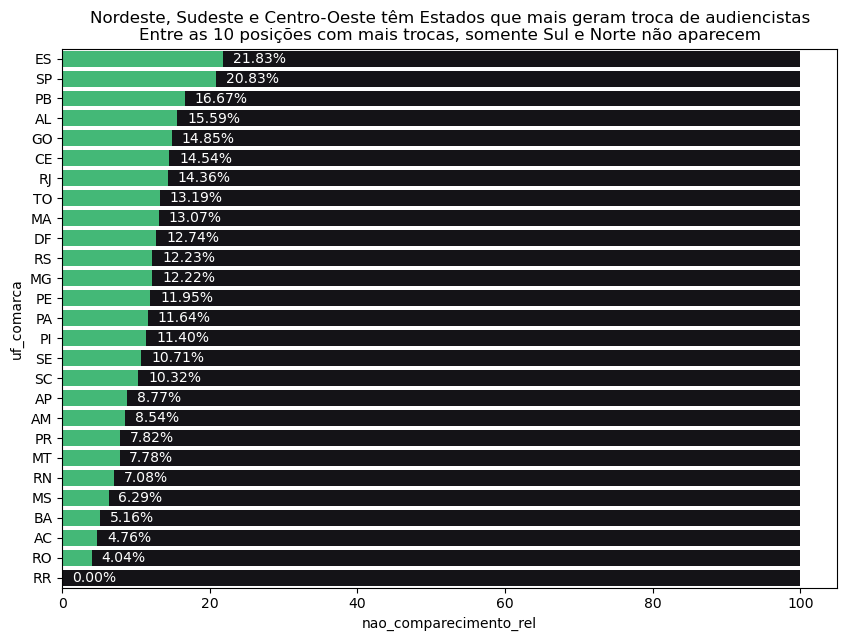

In [8]:
plt.figure(figsize=(10, 7))

total_comp_uf_plt = (
    sns.barplot(
        sol_inviab_uf[['uf_comarca', 'nao_comparecimento_rel']],
        y='uf_comarca',
        x=100,
        orient='y',
        color='#131218'
        )

)

inviab_comp_uf_plt = (
    sns.barplot(
        sol_inviab_uf[['uf_comarca', 'nao_comparecimento_rel']],
        y='uf_comarca',
        x='nao_comparecimento_rel',
        orient='h',
        color='#31cb74'
        )

)

for container in inviab_comp_uf_plt.containers:
    bar_values = [bar.get_width() for bar in container]
    if not all(val == 100 for val in bar_values):
        inviab_comp_uf_plt.bar_label(container, fmt='{:.2f}%', color='white', padding=7, label_type='edge' )

plt.title(
    'Nordeste, Sudeste e Centro-Oeste têm Estados que mais geram troca de audiencistas\n' + \
        'Entre as 10 posições com mais trocas, somente Sul e Norte não aparecem'
    );

## Porcentagem de solicitações não atendidas por tipo de audiência

É possível realizar uma operação semelhante para analisar os processos que receberam o mesmo tratamento, mas observando sob a ótica do tipo de audiência.

In [9]:
(
    df
    .assign(
        total_nao_comparecimento=lambda x: x['qtd_troca'] + x['qtd_declinio']
        )
    .groupby('tipo_audiencia')
    [['qtd_troca', 'qtd_declinio', 'total_nao_comparecimento']]
    
    .describe()
)

qtd_troca                                               \
                           count      mean       std  min  25%  50%  75%  max   
tipo_audiencia                                                                  
Assembleia de credores      10.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   
Conciliacao              12292.0  0.061015  0.288674  0.0  0.0  0.0  0.0  4.0   
Inicial                   3350.0  0.070149  0.321665  0.0  0.0  0.0  0.0  3.0   
Instrucao                 7441.0  0.079962  0.321167  0.0  0.0  0.0  0.0  3.0   
Sustentação Oral            35.0  0.114286  0.322803  0.0  0.0  0.0  0.0  1.0   
UNA                       6870.0  0.069578  0.306845  0.0  0.0  0.0  0.0  3.0   

                       qtd_declinio            ...            \
                              count      mean  ...  75%  max   
tipo_audiencia                                 ...             
Assembleia de credores         10.0  0.000000  ...  0.0  0.0   
Conciliacao                 12292.0  0.040026  ...  0.0  2.0   
Inicial                      3350.0  0.053134  ...  0.0  3.0   
Instrucao                    7441.0  0.082785  ...  0.0  3.0   
Sustentação Oral               35.0  0.114286  ...  0.0  2.0   
UNA                          6870.0  0.085153  ...  0.0  2.0   

                       total_nao_comparecimento                                \
                                          count      mean       std  min  25%   
tipo_audiencia                                                                  
Assembleia de credores                     10.0  0.000000  0.000000  0.0  0.0   
Conciliacao                             12292.0  0.101041  0.351028  0.0  0.0   
Inicial                                  3350.0  0.123284  0.400091  0.0  0.0   
Instrucao                                7441.0  0.162747  0.430353  0.0  0.0   
Sustentação Oral                           35.0  0.228571  0.490241  0.0  0.0   
UNA                                      6870.0  0.154731  0.434453  0.0  0.0   

                                       
                        50%  75%  max  
tipo_audiencia                         
Assembleia de credores  0.0  0.0  0.0  
Conciliacao             0.0  0.0  4.0  
Inicial                 0.0  0.0  4.0  
Instrucao               0.0  0.0  3.0  
Sustentação Oral        0.0  0.0  2.0  
UNA                     0.0  0.0  3.0  

[6 rows x 24 columns]

Novamente a tabela de estatísticas pode ser de difícil compreensão, momento em que a visualização dos dados novamente vem à tona.

In [10]:
sol_inviab_ta = (
    df
    .groupby(['tipo_audiencia'])
    .agg({
        'id_solicitacao': 'count',
        'qtd_troca': 'sum',
        'qtd_declinio': 'sum',
        }
        )
    .rename(columns={'id_solicitacao': 'qtd_solicitacoes'})
    .assign(
        total_nao_comparecimento=lambda x: x['qtd_troca'] + x['qtd_declinio'],
        nao_comparecimento_rel=lambda x:  (x['total_nao_comparecimento'] / x['qtd_solicitacoes']) * 100
        )
    .sort_values('nao_comparecimento_rel', ascending=False)
    .reset_index()
)

sol_inviab_ta

,tipo_audiencia,qtd_solicitacoes,qtd_troca,qtd_declinio,total_nao_comparecimento,nao_comparecimento_rel
0,Sustentação Oral,35,4,4,8,22.857143
1,Instrucao,7441,595,616,1211,16.274694
2,UNA,6870,478,585,1063,15.473071
3,Inicial,3350,235,178,413,12.328358
4,Conciliacao,12292,750,492,1242,10.104133
5,Assembleia de credores,10,0,0,0,0.000000


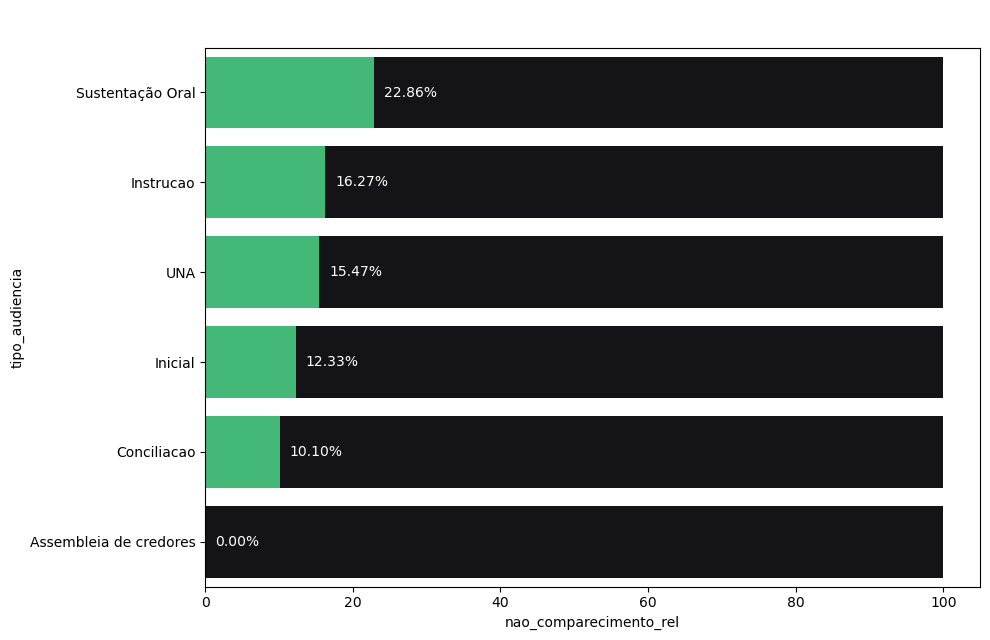

In [11]:
plt.figure(figsize=(10, 7))

total_inviab_ta_plt = (
    sns.barplot(
        sol_inviab_ta[['tipo_audiencia', 'nao_comparecimento_rel']],
        y='tipo_audiencia',
        x=100,
        orient='y',
        color='#131218'
        )

)

sol_inviab_ta_plt = (
    sns.barplot(
        sol_inviab_ta[['tipo_audiencia', 'nao_comparecimento_rel']],
        y='tipo_audiencia',
        x='nao_comparecimento_rel',
        orient='h',
        color='#31cb74'
        )

)

for container in total_inviab_ta_plt.containers:
    bar_values = [bar.get_width() for bar in container]
    if not all(val == 100 for val in bar_values):  # 
        total_inviab_ta_plt.bar_label(container, fmt='{:.2f}%', color='white', padding=7, label_type='edge' )

plt.title(
    '\n' + \
        ''
    );

In [12]:
sol_inviab_ta

,tipo_audiencia,qtd_solicitacoes,qtd_troca,qtd_declinio,total_nao_comparecimento,nao_comparecimento_rel
0,Sustentação Oral,35,4,4,8,22.857143
1,Instrucao,7441,595,616,1211,16.274694
2,UNA,6870,478,585,1063,15.473071
3,Inicial,3350,235,178,413,12.328358
4,Conciliacao,12292,750,492,1242,10.104133
5,Assembleia de credores,10,0,0,0,0.000000
